In [1]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pl_examples.basic_examples.mnist_datamodule import MNISTDataModule

import GradCertModule

ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.025          # Input Peturbation Budget at Training Time
GAMMA = 0.00            # Model Peturbation Budget at Training Time 
                        #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.001     # Learning Rate Hyperparameter
HIDDEN_DIM = 128       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 1         # Hidden Layers Hyperparameter
MAX_EPOCHS = 20
BATCH_SIZE = 100

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so
  Expected in: /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import XAIArchitectures
model = XAIArchitectures.FullyConnected(mode="L2ADV")
model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA,
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR,gamma_linear=GAMMA_LINEAR)
model.inputfooling_ON()

SET MODE TO:  L2ADV


In [3]:
print(model.inputfooling)

True


In [4]:

dm = MNISTDataModule(batch_size=BATCH_SIZE, num_workers=0)
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator="cpu", devices=1)
trainer.fit(model, datamodule=dm)
result = trainer.test(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | lays | ModuleList | 101 K 
1 | l1   | Linear     | 100 K 
2 | lf   | Linear     | 1.3 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an check

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9775000810623169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [5]:
ACC = round(result[0]['test_acc'],2)
print(ACC)

0.98


In [6]:
# Finally, we save the model IDed by its relevant parameters
import os
directory = "RegularizedModels"
if not os.path.exists(directory):
    os.makedirs(directory)
SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR
MODEL_ID = "FCN_e=%s_g=%s_a=%s_s=%s"%(EPSILON, GAMMA, ALPHA, SCHEDULED)
trainer.save_checkpoint("RegularizedModels/%s.ckpt"%(MODEL_ID))
torch.save(model.state_dict(), "RegularizedModels/%s.pt"%(MODEL_ID))

In [7]:
import torchvision.datasets as datasets
device = torch.device("cpu")
mnist_trainset = datasets.MNIST(root='./Datasets', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./Datasets', train=False, download=True, transform=None)


In [8]:
import numpy as np
from GradCertModule import run_mnist_attack
def compute_fooling_rate(model, eps_test = [0.35], forward=True):
    fool_i, fool_j = 4, 4
    success = [int(10) for i in range(50)]
    if(not forward):
        eps_test = list(reversed(eps_test))
    for eps in eps_test:
        print("******** COMPUTING FOR EPS = %s *********"%(eps))
        for i in range(20):
            if(success[i] != 10):
                continue
            data = np.asarray(mnist_testset[i][0])/255.0
            data = torch.Tensor(data)
            b_val, x_adv, grad_adv, targex, loss = run_mnist_attack(model, data, target = [4, 4], 
                                                            epsilon=eps, iterations=300, lr=0.01)
            if(loss <= 0.0385 and forward): # Heuristic Threshold for Fooling Rate
                success[i] = eps
            elif(loss > 0.0385 and not forward):
                success[i] = eps
            print(loss, i)
            #grad_advs.append(grad_adv)

    fooling_rate = []
    for v in eps_test:
        val = sum(i <= v for i in success)
        fooling_rate.append(val/len(success))
    return fooling_rate

compute_fooling_rate(model)

******** COMPUTING FOR EPS = 0.35 *********


Loss: 0.037311870604753494: 100%|████████████| 300/300 [00:01<00:00, 187.85it/s]


tensor(0.0373) 0


Loss: 0.03876655176281929: 100%|█████████████| 300/300 [00:01<00:00, 190.54it/s]


tensor(0.0388) 1


Loss: 0.03934292122721672: 100%|█████████████| 300/300 [00:01<00:00, 195.85it/s]


tensor(0.0393) 2


Loss: 0.03822499141097069: 100%|█████████████| 300/300 [00:01<00:00, 198.46it/s]


tensor(0.0382) 3


Loss: 0.04095056653022766: 100%|█████████████| 300/300 [00:01<00:00, 193.62it/s]


tensor(0.0410) 4


Loss: 0.039036061614751816: 100%|████████████| 300/300 [00:01<00:00, 196.49it/s]


tensor(0.0390) 5


Loss: 0.04102334380149841: 100%|█████████████| 300/300 [00:01<00:00, 200.31it/s]


tensor(0.0410) 6


Loss: 0.03919998183846474: 100%|█████████████| 300/300 [00:01<00:00, 181.66it/s]


tensor(0.0392) 7


Loss: 0.041456859558820724: 100%|████████████| 300/300 [00:01<00:00, 187.75it/s]


tensor(0.0415) 8


Loss: 0.039459772408008575: 100%|████████████| 300/300 [00:01<00:00, 195.30it/s]


tensor(0.0395) 9


Loss: 0.0389181450009346: 100%|██████████████| 300/300 [00:01<00:00, 194.37it/s]


tensor(0.0389) 10


Loss: 0.038221560418605804: 100%|████████████| 300/300 [00:01<00:00, 192.69it/s]


tensor(0.0382) 11


Loss: 0.039044808596372604: 100%|████████████| 300/300 [00:01<00:00, 188.36it/s]


tensor(0.0390) 12


Loss: 0.03847362473607063: 100%|█████████████| 300/300 [00:01<00:00, 190.17it/s]


tensor(0.0385) 13


Loss: 0.03811872750520706: 100%|█████████████| 300/300 [00:01<00:00, 195.80it/s]


tensor(0.0381) 14


Loss: 0.03975465148687363: 100%|█████████████| 300/300 [00:01<00:00, 192.50it/s]


tensor(0.0398) 15


Loss: 0.03926882892847061: 100%|█████████████| 300/300 [00:01<00:00, 171.67it/s]


tensor(0.0393) 16


Loss: 0.03826119005680084: 100%|█████████████| 300/300 [00:01<00:00, 183.15it/s]


tensor(0.0383) 17


Loss: 0.03948446363210678: 100%|█████████████| 300/300 [00:01<00:00, 182.10it/s]


tensor(0.0395) 18


Loss: 0.04075220227241516: 100%|█████████████| 300/300 [00:01<00:00, 197.83it/s]


tensor(0.0408) 19


[0.12]

In [9]:

from torch.nn import functional as F
def certify_model(model, data, target, eps=0.1):
    
    min_grad, max_grad = GradCertModule.GradCertBounds(model, data, target, eps, 0)
    min_grad, max_grad = min_grad.detach().numpy().reshape(28,28), max_grad.detach().numpy().reshape(28,28)
    
    #print(min_grad, max_grad)
    
    y_l, y_u = GradCertModule.RobustnessBounds(model, data, target, eps=eps, gam=0.0)
    
    data = data.detach().numpy().reshape(28,28)
    data = torch.Tensor(data)
    
    targets = [[4,4], [5,5], [6,6], [7,7], [24,4], [23,5], [22,6], [21,7],
              [4,24], [5,23], [6,22], [7,21], [24,24], [23,23], [22,22], [21,21]]
    lowest_loss = 1000
    for t in targets:
        targ_i, targ_j = t
        targex = np.asarray(min_grad) * 0.0
        targex[targ_i-4:targ_i+4,targ_j-4:targ_j+4] = 1
        v_cert = 0.0*targex
        v_cert += np.where(targex > max_grad, max_grad, 0) # if targex is larger than max, take the max
        v_cert += np.where(targex < min_grad, min_grad, 0) # if targex is less than min take, min
        inds = np.where((targex <= max_grad) & (targex >= min_grad)) # if targex is between take targex
        v_cert[inds] = targex[inds]
        #print(type(v_cert), type(targex))
        loss_expl = F.mse_loss(torch.Tensor(v_cert), torch.Tensor(targex))
        if(loss_expl < lowest_loss):
            lowest_loss = loss_expl
    #loss_expl = F.mse_loss(closest_exp, targex)
    #loss_output = F.mse_loss(torch.nn.functional.one_hot(target, num_classes=10), y_u.detach())
    total_loss = lowest_loss 
        
    return total_loss


def get_cert_rate(model, eps_t, eps, n=1000):
    certified = 0
    for i in range(n):
        data = np.asarray(mnist_testset[i][0]).reshape(1,28*28)/255.0
        data = torch.Tensor(data)
        target = torch.Tensor([mnist_testset[i][1]]).type(torch.LongTensor)
        val = certify_model(model, data, target, eps=eps)
        if(val > 0.0385):
            certified += 1
    return certified/n
get_cert_rate(model, 0.0125, 0.0125)
#get_cert_rate(model, 0.01, 0.01)

0.105

/Users/matthewwicker/opt/anaconda3/envs/FairnessAndPrivacy/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


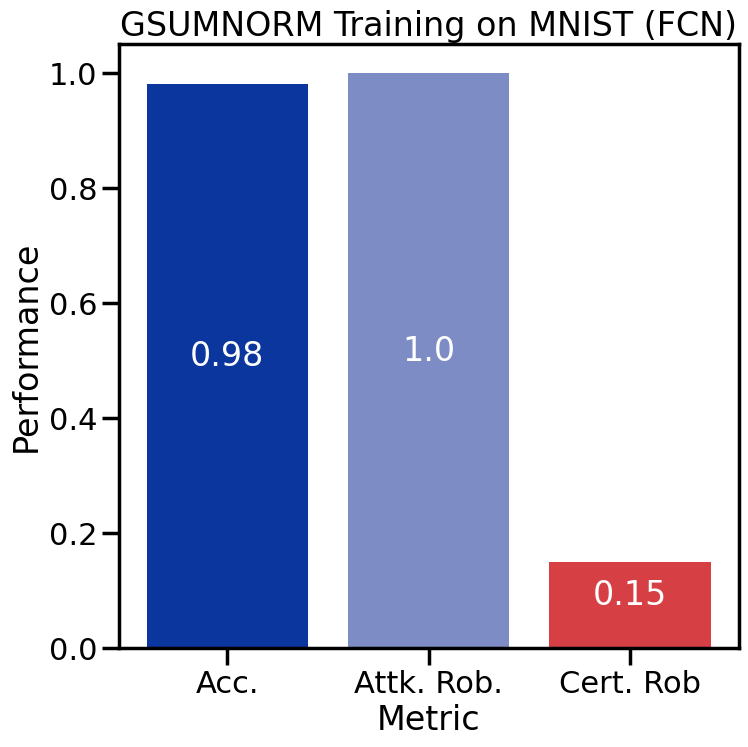

In [17]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.gca()

dataset = "MNIST"
vals = [0.98, 1.0, 0.15]
plt.bar([0,1,2], vals, color=['#0A369D', '#7D8CC4', '#D64045'])
plt.title("GSUMNORM Training on %s (FCN)"%(dataset))
plt.ylabel("Performance")
plt.xlabel(r"Metric")

for i in range(3):
    if(i==2):
        plt.text(i, vals[i]/2, vals[i], ha = 'center', c='w')
    else:
        plt.text(i, vals[i]/2, vals[i], ha = 'center', c='w')
        
        
ax.set_xticklabels(['', 'Acc.', 'Attk. Rob.', 'Cert. Rob'])

plt.show()
